# UMAP kurulumu

In [15]:
import sys, subprocess

def ensure_umap():
    try:
        import umap 
        print("umap-learn OK (zaten kurulu)")
        return True
    except Exception as e:
        print("umap-learn yok, kuruluyor... ->", repr(e))
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
        import umap 
        print("umap-learn OK (kuruldu)")
        return True

ensure_umap()


umap-learn OK (zaten kurulu)


True

# Import + Seed + Hız ayarları + Path

In [16]:
import os, struct, csv, math, time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("TensorFlow:", tf.__version__)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)

try:
    tf.config.optimizer.set_jit(True)
    print("XLA: enabled")
except Exception as e:
    print("XLA enable failed:", e)

USE_MIXED = len(gpus) > 0
try:
    from tensorflow.keras import mixed_precision
    if USE_MIXED:
        mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision:", mixed_precision.global_policy())
    else:
        mixed_precision.set_global_policy("float32")
        print("Mixed precision: disabled ->", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision set failed:", e)

DATA_DIR = "/kaggle/input/fashionmnist"
OUT_DIR = "/kaggle/working/vae_outputs_v3"
os.makedirs(OUT_DIR, exist_ok=True)
print("Outputs will be saved to:", OUT_DIR)

def savefig(path, dpi=200):
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)


TensorFlow: 2.19.0
GPUs: []
XLA: enabled
Mixed precision: disabled -> <DTypePolicy "float32">
Outputs will be saved to: /kaggle/working/vae_outputs_v3


# Dataset (IDX okuma) + Normalize

In [17]:
def load_idx_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} in {path}")
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} in {path}")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images_path = os.path.join(DATA_DIR, "train-images-idx3-ubyte")
train_labels_path = os.path.join(DATA_DIR, "train-labels-idx1-ubyte")
test_images_path  = os.path.join(DATA_DIR, "t10k-images-idx3-ubyte")
test_labels_path  = os.path.join(DATA_DIR, "t10k-labels-idx1-ubyte")

x_train = load_idx_images(train_images_path)
y_train = load_idx_labels(train_labels_path)
x_test  = load_idx_images(test_images_path)
y_test  = load_idx_labels(test_labels_path)

x_train = (x_train.astype("float32") / 255.0)[..., None]
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)


Train: (60000, 28, 28, 1) (60000,)
Test : (10000, 28, 28, 1) (10000,)


# Noise + tf.data

In [18]:
def add_gaussian_noise(x, noise_factor=0.45):
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=1.0, seed=SEED, dtype=tf.float32)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x_noisy = tf.clip_by_value(x + noise_factor * noise, 0.0, 1.0)
    return x_noisy

NOISE_FACTOR = 0.45
x_train_noisy = add_gaussian_noise(x_train, NOISE_FACTOR)
x_test_noisy  = add_gaussian_noise(x_test,  NOISE_FACTOR)

BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train, y_train))
    .shuffle(20000, seed=SEED)
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)


# Model (Encoder/Decoder)

In [19]:
LATENT_DIM = 16

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        dtype = z_mean.dtype
        eps = tf.random.normal(tf.shape(z_mean), seed=SEED, dtype=dtype)
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def conv_block(x, filters, k=3, s=1):
    x = layers.Conv2D(filters, k, strides=s, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def deconv_block(x, filters, k=3, s=2):
    x = layers.Conv2DTranspose(filters, k, strides=s, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def build_encoder(latent_dim=LATENT_DIM):
    inp = keras.Input(shape=(28, 28, 1), name="encoder_input")
    x = conv_block(inp, 32, 3, 2)   # 14x14
    x = conv_block(x, 64, 3, 2)     # 7x7
    x = conv_block(x, 128, 3, 1)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.1)(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="sampling")([z_mean, z_log_var])
    return keras.Model(inp, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim=LATENT_DIM):
    inp = keras.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(7 * 7 * 128)(inp)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = deconv_block(x, 64, 3, 2)   # 14x14
    x = deconv_block(x, 32, 3, 2)   # 28x28
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.LeakyReLU()(x)
    out = layers.Conv2D(1, 3, padding="same", activation="sigmoid", dtype="float32")(x)
    return keras.Model(inp, out, name="decoder")

encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)

encoder.summary()
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 7, 7, 64)  │     18,496 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ leaky_re_lu_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ leaky_re_lu_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  1,605,888 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 256)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,707,680 (6.51 MB)

 Trainable params: 1,707,232 (6.51 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6272)           │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,033 (797.00 KB)

 Trainable params: 203,841 (796.25 KB)

 Non-trainable params: 192 (768.00 B)

# Loss + SupCon + Warmup + VAE class

In [20]:
@tf.function
def recon_loss_bce(x_true, x_pred):
    bce = keras.backend.binary_crossentropy(x_true, x_pred)
    return tf.reduce_mean(tf.reduce_sum(bce, axis=[1, 2]))

@tf.function
def kl_divergence(z_mean, z_log_var):
    z_mean = tf.cast(z_mean, tf.float32)
    z_log_var = tf.cast(z_log_var, tf.float32)
    return -0.5 * tf.reduce_mean(tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    ))

@tf.function
def supervised_contrastive_loss(z, y, temperature=0.2):
    z = tf.cast(z, tf.float32)
    z = tf.math.l2_normalize(z, axis=1)

    y = tf.cast(y, tf.int32)
    y = tf.reshape(y, [-1, 1])
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)

    logits = tf.matmul(z, z, transpose_b=True) / temperature
    bsz = tf.shape(z)[0]
    logits_mask = tf.ones_like(mask) - tf.eye(bsz)
    mask = mask * logits_mask

    logits = logits - tf.reduce_max(logits, axis=1, keepdims=True)
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-12)

    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / (tf.reduce_sum(mask, axis=1) + 1e-12)
    return -tf.reduce_mean(mean_log_prob_pos)

class BetaWarmup(keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=8):
        super().__init__()
        self.beta_max = beta_max
        self.warmup_epochs = warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            beta = self.beta_max * (epoch + 1) / self.warmup_epochs
        else:
            beta = self.beta_max
        self.model.beta.assign(beta)

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta_max=1.0, gamma_sc=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.beta_max = beta_max
        self.gamma_sc = tf.Variable(gamma_sc, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.sc_loss_tracker = keras.metrics.Mean(name="supcon_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker, self.sc_loss_tracker]

    def train_step(self, data):
        x_noisy, x_clean, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_noisy, training=True)
            x_recon = self.decoder(z, training=True)

            r_loss = recon_loss_bce(x_clean, x_recon)
            k_loss = kl_divergence(z_mean, z_log_var)
            sc_loss = supervised_contrastive_loss(z_mean, y, temperature=0.2)

            total = r_loss + self.beta * k_loss + self.gamma_sc * sc_loss

        grads = tape.gradient(total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(r_loss)
        self.kl_loss_tracker.update_state(k_loss)
        self.sc_loss_tracker.update_state(sc_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "supcon_loss": self.sc_loss_tracker.result(),
            "beta": self.beta,
            "gamma_sc": self.gamma_sc
        }

    def test_step(self, data):
        x_noisy, x_clean, y = data
        z_mean, z_log_var, z = self.encoder(x_noisy, training=False)
        x_recon = self.decoder(z, training=False)

        r_loss = recon_loss_bce(x_clean, x_recon)
        k_loss = kl_divergence(z_mean, z_log_var)
        sc_loss = supervised_contrastive_loss(z_mean, y, temperature=0.2)

        total = r_loss + self.beta * k_loss + self.gamma_sc * sc_loss

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(r_loss)
        self.kl_loss_tracker.update_state(k_loss)
        self.sc_loss_tracker.update_state(sc_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "supcon_loss": self.sc_loss_tracker.result(),
            "beta": self.beta,
            "gamma_sc": self.gamma_sc
        }


# Train

In [21]:
EPOCHS = 80
GAMMA_SC = 0.15
BETA_MAX = 0.4
WARMUP_EPOCHS = 35

vae = VAE(encoder, decoder, beta_max=BETA_MAX, gamma_sc=GAMMA_SC)
vae.compile(optimizer = keras.optimizers.Adam(2e-4))

callbacks = [
    BetaWarmup(beta_max=BETA_MAX, warmup_epochs=WARMUP_EPOCHS),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

t0 = time.time()
history = vae.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("Training time (s):", round(time.time() - t0, 2))


Epoch 1/80
234/234 ━━━━━━━━━━━━━━━━━━━━ 140s 573ms/step - beta: 0.0114 - gamma_sc: 0.1500 - kl_loss: 157.9200 - loss: 335.8976 - recon_loss: 333.3365 - supcon_loss: 5.0420 - val_beta: 0.0114 - val_gamma_sc: 0.1500 - val_kl_loss: 20.3111 - val_loss: 392.1750 - val_recon_loss: 391.2376 - val_supcon_loss: 4.7013 - learning_rate: 2.0000e-04
Epoch 2/80
234/234 ━━━━━━━━━━━━━━━━━━━━ 133s 566ms/step - beta: 0.0229 - gamma_sc: 0.1500 - kl_loss: 95.0589 - loss: 240.1200 - recon_loss: 237.2278 - supcon_loss: 4.7960 - val_beta: 0.0229 - val_gamma_sc: 0.1500 - val_kl_loss: 54.7154 - val_loss: 257.3448 - val_recon_loss: 255.3884 - val_supcon_loss: 4.7051 - learning_rate: 2.0000e-04
Epoch 3/80
234/234 ━━━━━━━━━━━━━━━━━━━━ 131s 560ms/step - beta: 0.0343 - gamma_sc: 0.1500 - kl_loss: 69.9164 - loss: 235.8372 - recon_loss: 232.7188 - supcon_loss: 4.8080 - val_beta: 0.0343 - val_gamma_sc: 0.1500 - val_kl_loss: 62.5155 - val_loss: 234.9916 - val_recon_loss: 232.1402 - val_supcon_loss: 4.7201 - learning_ra

# Training Curves + history.csv (1-2-3A-3B-4)

Saved: /kaggle/working/vae_outputs_v3/01_train_total_loss.png


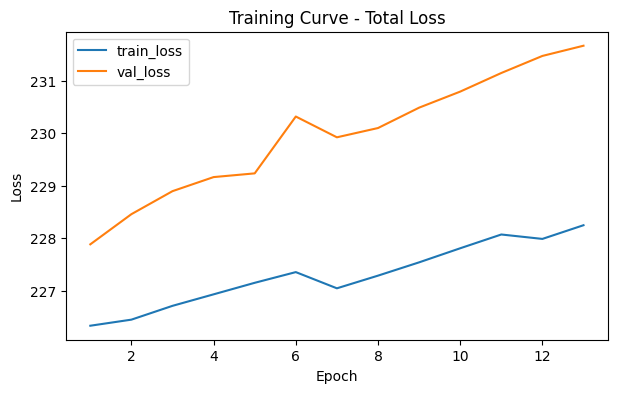

Saved: /kaggle/working/vae_outputs_v3/02_train_recon_loss.png


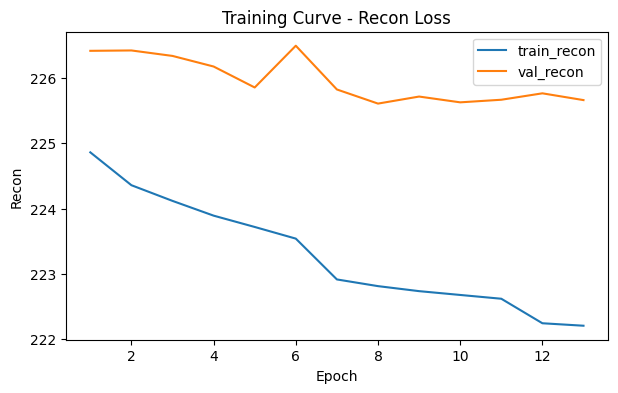

Saved: /kaggle/working/vae_outputs_v3/03A_train_kl_loss.png


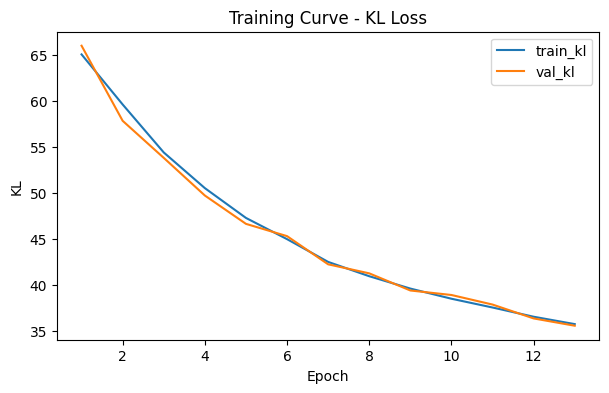

Saved: /kaggle/working/vae_outputs_v3/03B_train_supcon_loss.png


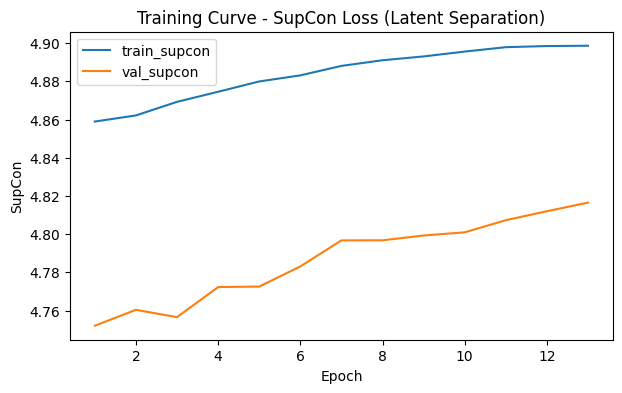

Saved: /kaggle/working/vae_outputs_v3/04_beta_warmup.png


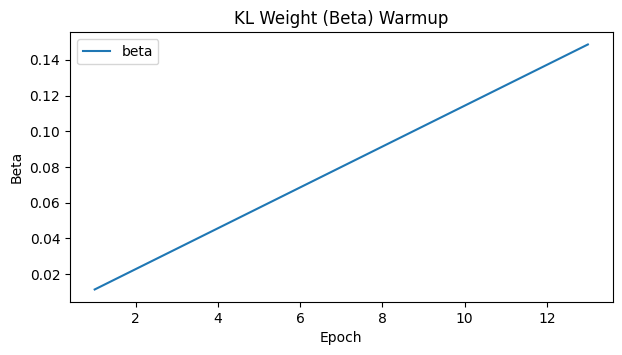

Saved: /kaggle/working/vae_outputs_v3/history.csv


In [24]:
def plot_history(hist):
    h = hist.history
    def safe_get(k): return h[k] if k in h else []
    epochs = np.arange(1, len(safe_get("loss")) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, safe_get("loss"), label="train_loss")
    if len(safe_get("val_loss")): plt.plot(epochs, safe_get("val_loss"), label="val_loss")
    plt.title("Training Curve - Total Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    savefig(os.path.join(OUT_DIR, "01_train_total_loss.png"))
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, safe_get("recon_loss"), label="train_recon")
    if len(safe_get("val_recon_loss")): plt.plot(epochs, safe_get("val_recon_loss"), label="val_recon")
    plt.title("Training Curve - Recon Loss")
    plt.xlabel("Epoch"); plt.ylabel("Recon"); plt.legend()
    savefig(os.path.join(OUT_DIR, "02_train_recon_loss.png"))
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, safe_get("kl_loss"), label="train_kl")
    if len(safe_get("val_kl_loss")): plt.plot(epochs, safe_get("val_kl_loss"), label="val_kl")
    plt.title("Training Curve - KL Loss")
    plt.xlabel("Epoch"); plt.ylabel("KL"); plt.legend()
    savefig(os.path.join(OUT_DIR, "03A_train_kl_loss.png"))
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, safe_get("supcon_loss"), label="train_supcon")
    if len(safe_get("val_supcon_loss")): plt.plot(epochs, safe_get("val_supcon_loss"), label="val_supcon")
    plt.title("Training Curve - SupCon Loss (Latent Separation)")
    plt.xlabel("Epoch"); plt.ylabel("SupCon"); plt.legend()
    savefig(os.path.join(OUT_DIR, "03B_train_supcon_loss.png"))
    plt.show()

    if "beta" in h:
        plt.figure(figsize=(7,3.5))
        plt.plot(epochs, safe_get("beta"), label="beta")
        plt.title("KL Weight (Beta) Warmup")
        plt.xlabel("Epoch"); plt.ylabel("Beta"); plt.legend()
        savefig(os.path.join(OUT_DIR, "04_beta_warmup.png"))
        plt.show()

plot_history(history)

hist_csv = os.path.join(OUT_DIR, "history.csv")
with open(hist_csv, "w", newline="") as f:
    writer = csv.writer(f)
    keys = list(history.history.keys())
    writer.writerow(["epoch"] + keys)
    for i in range(len(history.history[keys[0]])):
        writer.writerow([i+1] + [history.history[k][i] for k in keys])
print("Saved:", hist_csv)


# Denoising Grid (5)

Saved: /kaggle/working/vae_outputs_v3/05_denoising_grid.png


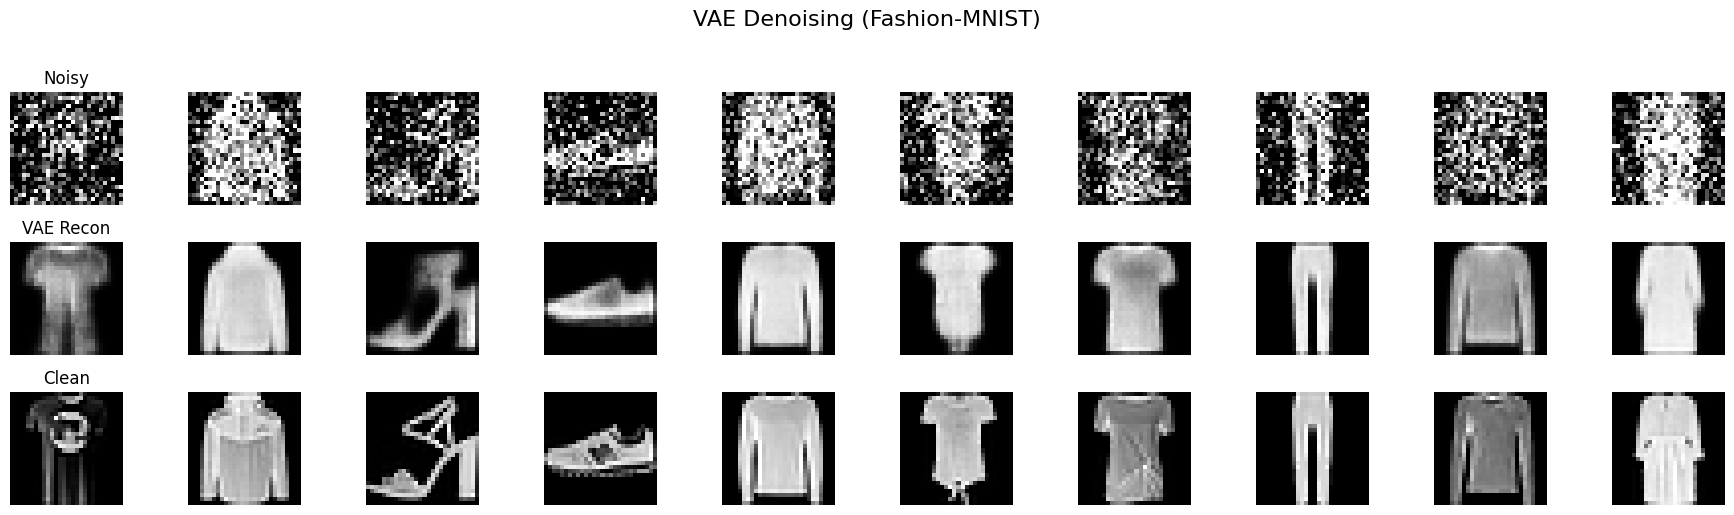

In [25]:
def show_denoising_examples(n=10, seed=SEED, fname="05_denoising_grid.png"):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x_test), size=n, replace=False)

    xN = tf.gather(x_test_noisy, idx)
    xC = tf.gather(x_test, idx)

    z_mean, z_log_var, z = encoder(xN, training=False)
    xR = decoder(z, training=False)

    plt.figure(figsize=(n*1.8, 5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        plt.imshow(xN[i, :, :, 0], cmap="gray"); plt.axis("off")
        if i == 0: ax.set_title("Noisy")

        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(xR[i, :, :, 0], cmap="gray"); plt.axis("off")
        if i == 0: ax.set_title("VAE Recon")

        ax = plt.subplot(3, n, i+1+2*n)
        plt.imshow(xC[i, :, :, 0], cmap="gray"); plt.axis("off")
        if i == 0: ax.set_title("Clean")

    plt.suptitle("VAE Denoising (Fashion-MNIST)", y=1.02, fontsize=16)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

show_denoising_examples(10)


# Metrics (metrics.txt / metrics.csv)

In [26]:
def mse(a, b):
    a = tf.cast(a, tf.float32); b = tf.cast(b, tf.float32)
    return tf.reduce_mean(tf.square(a - b))

def mean_psnr(a, b):
    a = tf.cast(a, tf.float32); b = tf.cast(b, tf.float32)
    return tf.reduce_mean(tf.image.psnr(a, b, max_val=1.0))

def mean_ssim(a, b):
    a = tf.cast(a, tf.float32); b = tf.cast(b, tf.float32)
    return tf.reduce_mean(tf.image.ssim(a, b, max_val=1.0))

all_noisy = x_test_noisy
all_clean = x_test

z_mean_all, z_log_var_all, z_all = encoder(all_noisy, training=False)
all_recon = decoder(z_all, training=False)

mse_noisy = float(mse(all_noisy, all_clean).numpy())
mse_vae   = float(mse(all_recon, all_clean).numpy())

psnr_noisy = float(mean_psnr(all_noisy, all_clean).numpy())
psnr_vae   = float(mean_psnr(all_recon, all_clean).numpy())

ssim_noisy = float(mean_ssim(all_noisy, all_clean).numpy())
ssim_vae   = float(mean_ssim(all_recon, all_clean).numpy())

mse_improve_pct = (mse_noisy - mse_vae) / (mse_noisy + 1e-12) * 100.0
psnr_gain = psnr_vae - psnr_noisy
ssim_gain = ssim_vae - ssim_noisy

print("\n=== Denoising Metrics (Test) ===")
print(f"NOISE_FACTOR={NOISE_FACTOR} | LATENT_DIM={LATENT_DIM} | BATCH={BATCH_SIZE} | EPOCHS={EPOCHS}")
print(f"Baseline (Noisy->Clean)  MSE={mse_noisy:.6f} | PSNR={psnr_noisy:.3f} dB | SSIM={ssim_noisy:.4f}")
print(f"VAE (Recon->Clean)       MSE={mse_vae:.6f} | PSNR={psnr_vae:.3f} dB | SSIM={ssim_vae:.4f}")
print("\n=== Improvement (Higher is better) ===")
print(f"MSE improvement: {mse_improve_pct:.2f}% (↓)")
print(f"PSNR gain      : {psnr_gain:.3f} dB (↑)")
print(f"SSIM gain      : {ssim_gain:.4f} (↑)")

metrics_txt = os.path.join(OUT_DIR, "metrics.txt")
with open(metrics_txt, "w") as f:
    f.write("=== Denoising Metrics (Test) ===\n")
    f.write(f"NOISE_FACTOR={NOISE_FACTOR}\nLATENT_DIM={LATENT_DIM}\nBATCH_SIZE={BATCH_SIZE}\nEPOCHS={EPOCHS}\n\n")
    f.write(f"Baseline (Noisy->Clean)  MSE={mse_noisy:.6f} | PSNR={psnr_noisy:.3f} dB | SSIM={ssim_noisy:.4f}\n")
    f.write(f"VAE (Recon->Clean)       MSE={mse_vae:.6f} | PSNR={psnr_vae:.3f} dB | SSIM={ssim_vae:.4f}\n\n")
    f.write("=== Improvement ===\n")
    f.write(f"MSE improvement: {mse_improve_pct:.2f}%\n")
    f.write(f"PSNR gain      : {psnr_gain:.3f} dB\n")
    f.write(f"SSIM gain      : {ssim_gain:.4f}\n")
print("Saved:", metrics_txt)

metrics_csv = os.path.join(OUT_DIR, "metrics.csv")
with open(metrics_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric", "baseline_noisy_to_clean", "vae_recon_to_clean", "delta_or_improvement"])
    w.writerow(["MSE",  mse_noisy,  mse_vae,  mse_improve_pct])
    w.writerow(["PSNR_dB", psnr_noisy, psnr_vae, psnr_gain])
    w.writerow(["SSIM", ssim_noisy, ssim_vae, ssim_gain])
print("Saved:", metrics_csv)



=== Denoising Metrics (Test) ===
NOISE_FACTOR=0.45 | LATENT_DIM=16 | BATCH=256 | EPOCHS=80
Baseline (Noisy->Clean)  MSE=0.101500 | PSNR=9.945 dB | SSIM=0.2871
VAE (Recon->Clean)       MSE=0.014968 | PSNR=18.851 dB | SSIM=0.6352

=== Improvement (Higher is better) ===
MSE improvement: 85.25% (↓)
PSNR gain      : 8.905 dB (↑)
SSIM gain      : 0.3481 (↑)
Saved: /kaggle/working/vae_outputs_v3/metrics.txt
Saved: /kaggle/working/vae_outputs_v3/metrics.csv


# Representation PCA (06A, 06B + variance txt)

Saved: /kaggle/working/vae_outputs_v3/06A_latent_pca_numbers.png


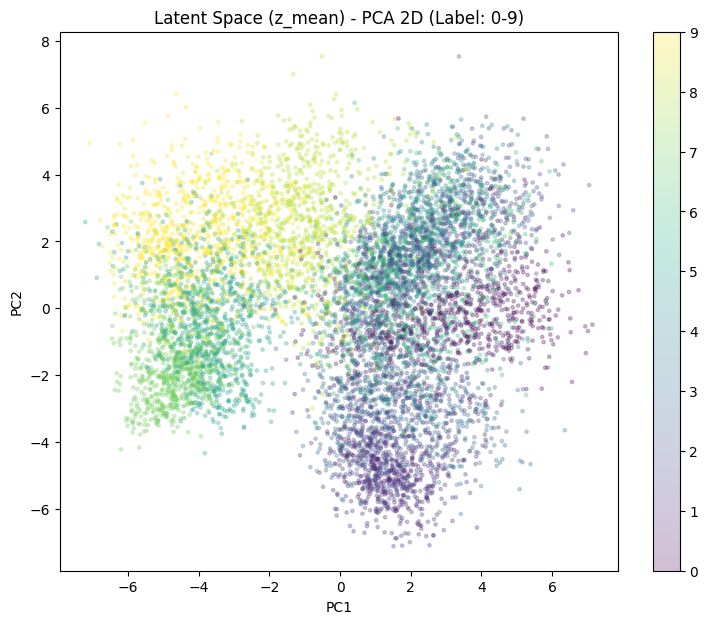

Saved: /kaggle/working/vae_outputs_v3/06B_latent_pca_text_tr.png


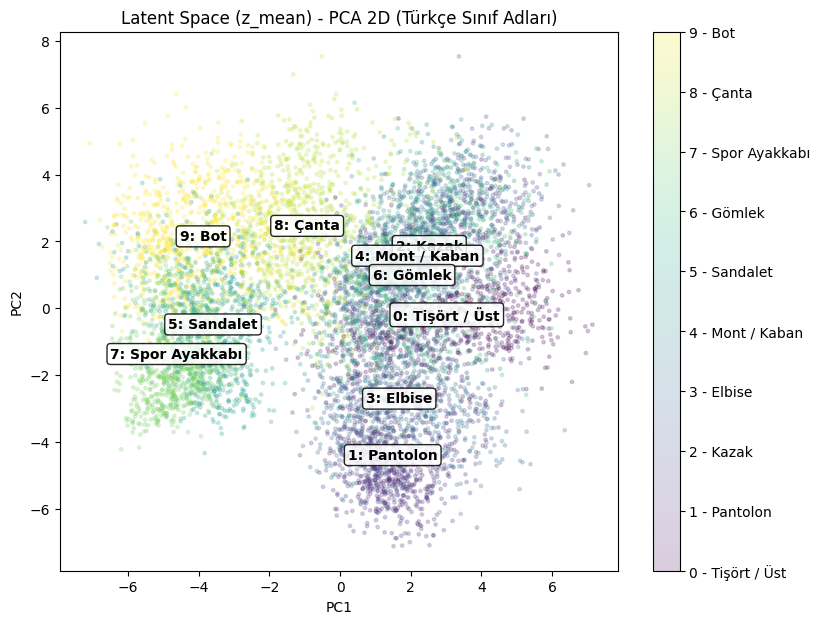

Saved: /kaggle/working/vae_outputs_v3/pca_explained_variance.txt


In [27]:
FASHION_LABELS_TR = {
    0: "Tişört / Üst",
    1: "Pantolon",
    2: "Kazak",
    3: "Elbise",
    4: "Mont / Kaban",
    5: "Sandalet",
    6: "Gömlek",
    7: "Spor Ayakkabı",
    8: "Çanta",
    9: "Bot"
}

def plot_latent_pca_tr(N_VIS=8000, use_noisy=True,
                       fnameA="06A_latent_pca_numbers.png",
                       fnameB="06B_latent_pca_text_tr.png"):
    y_vis = y_test[:N_VIS]
    x_for_latent = x_test_noisy[:N_VIS] if use_noisy else x_test[:N_VIS]

    z_mean_vis, _, _ = encoder(tf.convert_to_tensor(x_for_latent, dtype=tf.float32), training=False)
    z_mean_vis = z_mean_vis.numpy()

    pca = PCA(n_components=2, random_state=SEED)
    z2 = pca.fit_transform(z_mean_vis)

    plt.figure(figsize=(9,7))
    sc = plt.scatter(z2[:,0], z2[:,1], c=y_vis, s=6, alpha=0.25)
    plt.colorbar(sc, ticks=range(10))
    plt.title("Latent Space (z_mean) - PCA 2D (Label: 0-9)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    savefig(os.path.join(OUT_DIR, fnameA))
    plt.show()

    plt.figure(figsize=(9,7))
    sc2 = plt.scatter(z2[:,0], z2[:,1], c=y_vis, s=6, alpha=0.20)
    cbar2 = plt.colorbar(sc2, ticks=range(10))
    cbar2.ax.set_yticklabels([f"{i} - {FASHION_LABELS_TR[i]}" for i in range(10)])
    plt.title("Latent Space (z_mean) - PCA 2D (Türkçe Sınıf Adları)")
    plt.xlabel("PC1"); plt.ylabel("PC2")

    for cls in range(10):
        mask = (y_vis == cls)
        if np.sum(mask) == 0:
            continue
        cx = np.mean(z2[mask, 0]); cy = np.mean(z2[mask, 1])
        plt.text(cx, cy, f"{cls}: {FASHION_LABELS_TR[cls]}",
                 fontsize=10, fontweight="bold",
                 ha="center", va="center",
                 bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.85))

    savefig(os.path.join(OUT_DIR, fnameB))
    plt.show()

    pca_txt = os.path.join(OUT_DIR, "pca_explained_variance.txt")
    with open(pca_txt, "w") as f:
        f.write("PCA Explained Variance Ratio (2 components)\n")
        f.write(str(pca.explained_variance_ratio_) + "\n")
        f.write("Sum: " + str(np.sum(pca.explained_variance_ratio_)) + "\n")
    print("Saved:", pca_txt)

plot_latent_pca_tr(N_VIS=8000, use_noisy=True)


# 06C (UMAP) + 06D (t-SNE)

Saved: 06C_latent_umap_text_tr.png


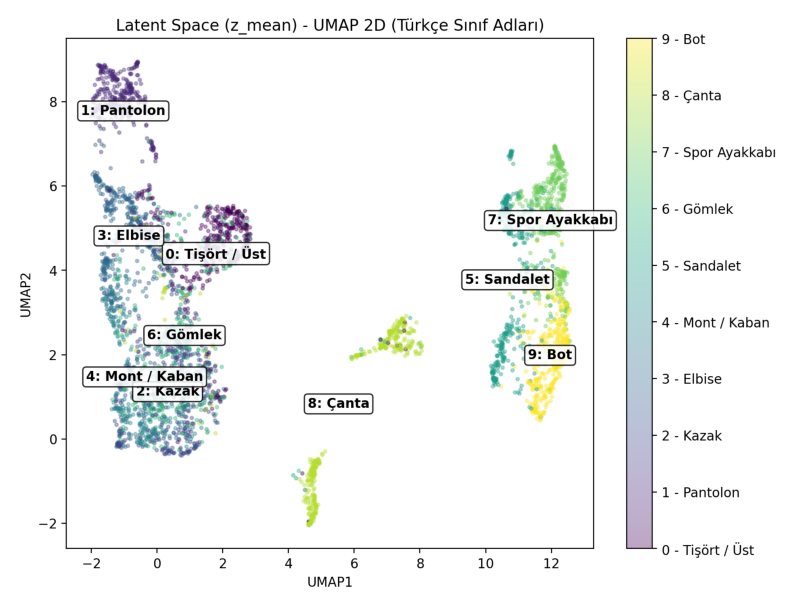

Saved: 06D_latent_tsne_text_tr.png


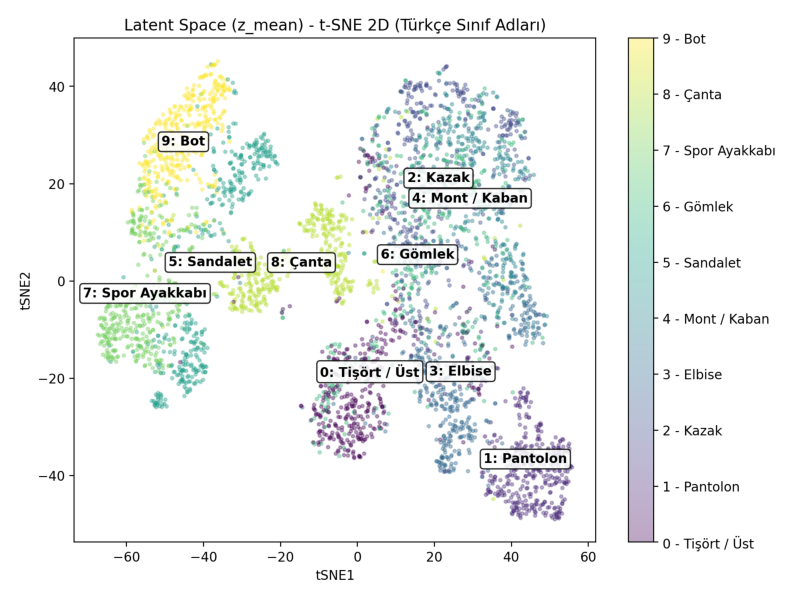

In [28]:
import os, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
sys.setrecursionlimit(20000)

OUT_DIR = globals().get("OUT_DIR", "./outputs")
os.makedirs(OUT_DIR, exist_ok=True)

FASHION_LABELS_TR = globals().get(
    "FASHION_LABELS_TR",
    ["Tişört/Üst", "Pantolon", "Kazak", "Elbise", "Palto", "Sandalet", "Gömlek", "Spor Ayakkabı", "Çanta", "Bot"]
)
SEED = globals().get("SEED", 42)

def _save_png(fig, fname):
    path = os.path.join(OUT_DIR, fname)
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return path

def _get_zmean_y(N_VIS=4000, use_noisy=True):
    needed = ["encoder","x_test","y_test","x_test_noisy"]
    if any(k not in globals() for k in needed):
        return None, None

    y_vis = y_test[:N_VIS]
    x_for_latent = x_test_noisy[:N_VIS] if use_noisy else x_test[:N_VIS]

    import tensorflow as tf
    z_mean_vis, _, _ = encoder(tf.convert_to_tensor(x_for_latent, tf.float32), training=False)
    z_mean_vis = z_mean_vis.numpy().astype(np.float32)

    if not np.isfinite(z_mean_vis).all():
        z_mean_vis = np.nan_to_num(z_mean_vis, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

    return z_mean_vis, y_vis

def _plot_scatter(z2, y_vis, title, xlabel, ylabel):
    fig = plt.figure(figsize=(9,7))
    sc = plt.scatter(z2[:,0], z2[:,1], c=y_vis, s=6, alpha=0.35)
    cbar = plt.colorbar(sc, ticks=range(10))
    cbar.ax.set_yticklabels([f"{i} - {FASHION_LABELS_TR[i]}" for i in range(10)])
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)

    for cls in range(10):
        m = (y_vis == cls)
        if np.sum(m) == 0:
            continue
        cx, cy = float(np.mean(z2[m,0])), float(np.mean(z2[m,1]))
        plt.text(
            cx, cy, f"{cls}: {FASHION_LABELS_TR[cls]}",
            fontsize=10, fontweight="bold", ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", alpha=0.85)
        )
    return fig

def make_06C(N_VIS=4000, use_noisy=True, fname="06C_latent_umap_text_tr.png"):
    z_mean_vis, y_vis = _get_zmean_y(N_VIS, use_noisy)
    if z_mean_vis is None:
        return None
    try:
        import umap
        reducer = umap.UMAP(
            n_components=2, random_state=SEED,
            n_neighbors=25, min_dist=0.05,
            metric="euclidean", low_memory=True,
            n_epochs=200, init="spectral",
        )
        z2 = reducer.fit_transform(z_mean_vis)
        fig = _plot_scatter(z2, y_vis, "Latent Space (z_mean) - UMAP 2D (Türkçe Sınıf Adları)", "UMAP1", "UMAP2")
        return _save_png(fig, fname)
    except Exception:
        z2 = PCA(n_components=2, random_state=SEED).fit_transform(z_mean_vis)
        fig = _plot_scatter(z2, y_vis, "Latent Space (z_mean) - PCA fallback (UMAP çalışmadı)", "PC1", "PC2")
        return _save_png(fig, fname)

def make_06D(N_VIS=4000, use_noisy=True, fname="06D_latent_tsne_text_tr.png"):
    z_mean_vis, y_vis = _get_zmean_y(N_VIS, use_noisy)
    if z_mean_vis is None:
        return None
    try:
        z2 = TSNE(
            n_components=2, perplexity=35,
            learning_rate="auto", init="pca",
            random_state=SEED,
        ).fit_transform(z_mean_vis)
        fig = _plot_scatter(z2, y_vis, "Latent Space (z_mean) - t-SNE 2D (Türkçe Sınıf Adları)", "tSNE1", "tSNE2")
        return _save_png(fig, fname)
    except Exception:
        z2 = PCA(n_components=2, random_state=SEED).fit_transform(z_mean_vis)
        fig = _plot_scatter(z2, y_vis, "Latent Space (z_mean) - PCA fallback (t-SNE çalışmadı)", "PC1", "PC2")
        return _save_png(fig, fname)

def show_png(path):
    if (path is None) or (not os.path.exists(path)):
        return
    print(f"Saved: {os.path.basename(path)}")
    img = plt.imread(path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

p06c = make_06C(N_VIS=4000, use_noisy=True, fname="06C_latent_umap_text_tr.png")
p06d = make_06D(N_VIS=4000, use_noisy=True, fname="06D_latent_tsne_text_tr.png")

show_png(p06c)
show_png(p06d)


# Generation (07)

Saved: /kaggle/working/vae_outputs_v3/07_generated_prior.png


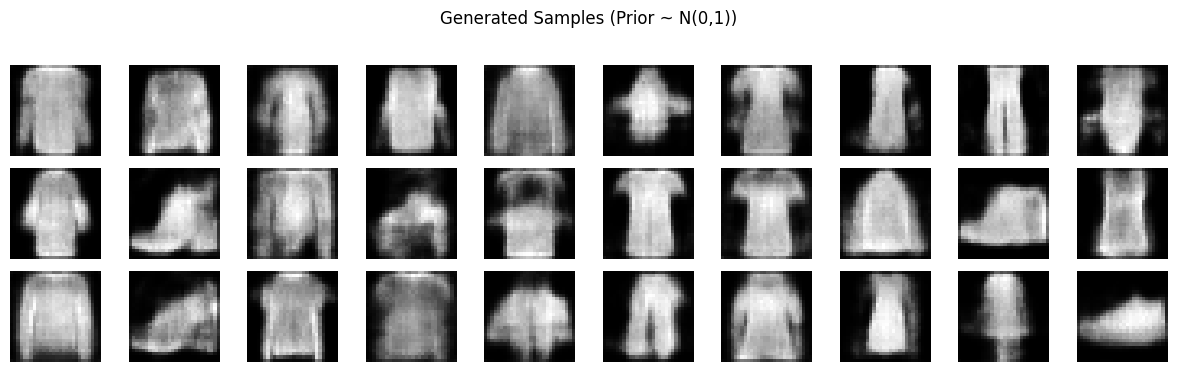

In [29]:
def sample_from_prior(n=30, seed=SEED, fname="07_generated_prior.png"):
    z = tf.random.normal(shape=(n, LATENT_DIM), seed=seed, dtype=tf.float32)
    x_gen = decoder(tf.cast(z, tf.float32), training=False).numpy()

    cols = 10
    rows = int(math.ceil(n/cols))
    plt.figure(figsize=(cols*1.2, rows*1.2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_gen[i,:,:,0], cmap="gray"); plt.axis("off")
    plt.suptitle("Generated Samples (Prior ~ N(0,1))", y=1.02)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

sample_from_prior(30)


# Interpolation (08)

Saved: /kaggle/working/vae_outputs_v3/08_latent_interpolation.png


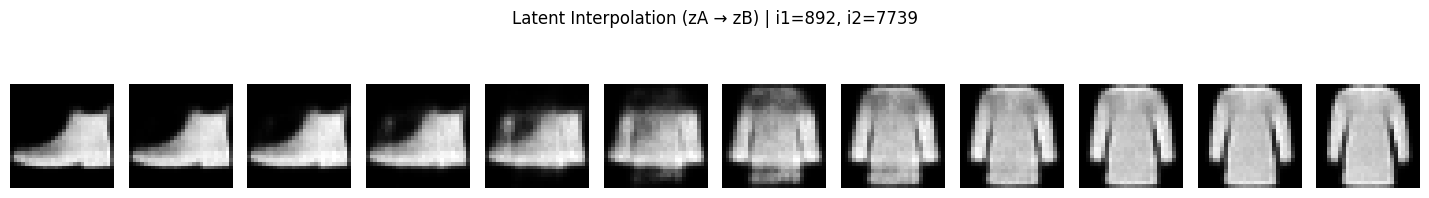

In [30]:
def latent_interpolation(steps=12, seed=SEED, fname="08_latent_interpolation.png"):
    rng = np.random.default_rng(seed)
    i1, i2 = rng.integers(0, len(x_test), size=2)

    xA = x_test_noisy[i1:i1+1]
    xB = x_test_noisy[i2:i2+1]

    zA_mean, _, _ = encoder(xA, training=False)
    zB_mean, _, _ = encoder(xB, training=False)

    alphas = np.linspace(0, 1, steps).astype("float32")
    z_interp = tf.concat([(1-a)*zA_mean + a*zB_mean for a in alphas], axis=0)
    x_interp = decoder(z_interp, training=False).numpy()

    plt.figure(figsize=(steps*1.2, 1.7))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(x_interp[i,:,:,0], cmap="gray"); plt.axis("off")
    plt.suptitle(f"Latent Interpolation (zA → zB) | i1={i1}, i2={i2}", y=1.15)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()
    return int(i1), int(i2)

i1, i2 = latent_interpolation()


# Title Paneller (A/B/C/D)

Saved: /kaggle/working/vae_outputs_v3/A_title_denoising.png


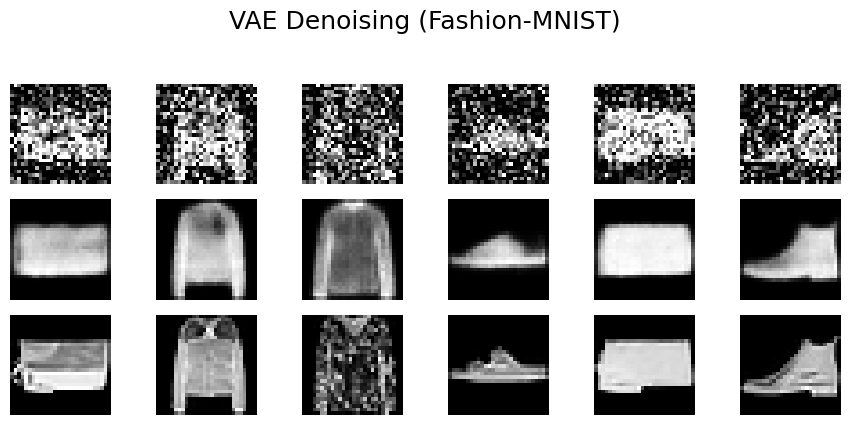

Saved: /kaggle/working/vae_outputs_v3/B_title_representation_learning.png


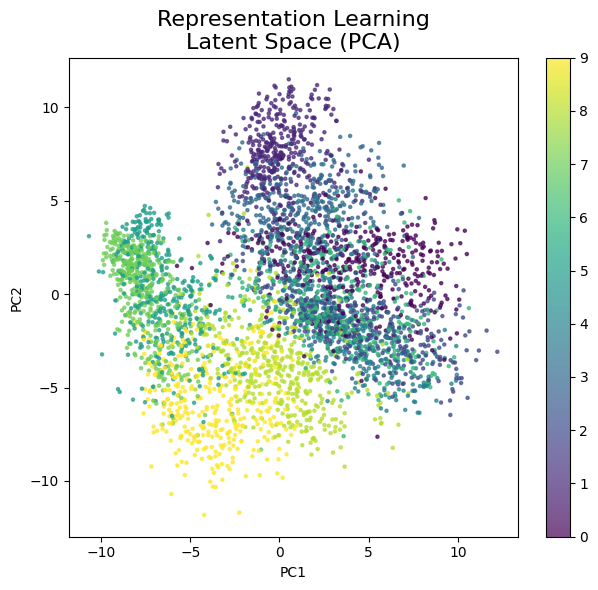

Saved: /kaggle/working/vae_outputs_v3/C_title_generation.png


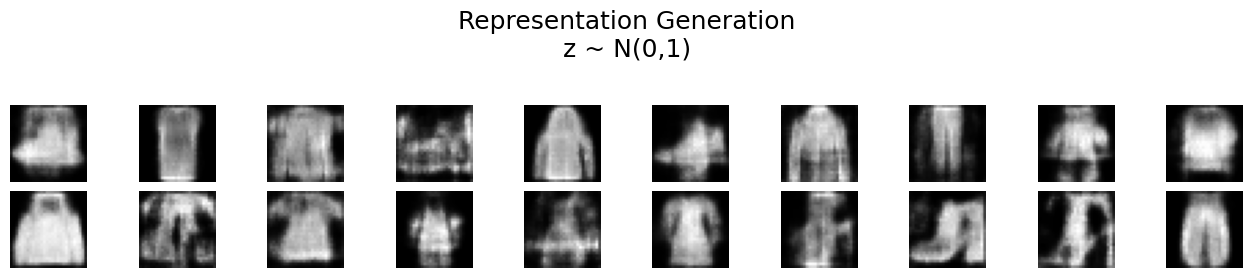

Saved: /kaggle/working/vae_outputs_v3/D_title_interpolation.png


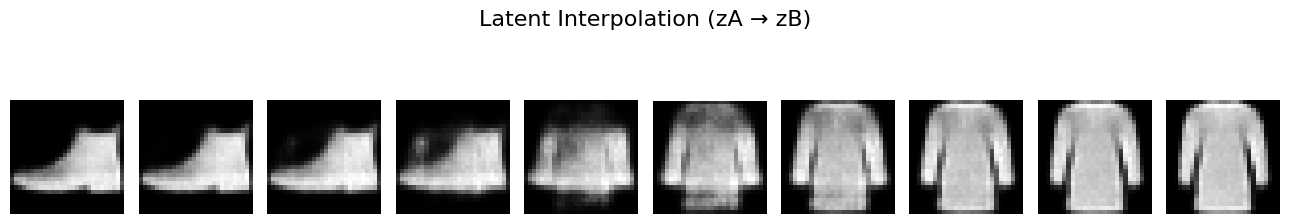

In [31]:
def title_panel_denoising(n=6, fname="A_title_denoising.png"):
    idx = np.random.default_rng(SEED).choice(len(x_test), n, replace=False)
    xN = tf.gather(x_test_noisy, idx)
    xC = tf.gather(x_test, idx)
    _, _, z = encoder(xN, training=False)
    xR = decoder(z, training=False)

    plt.figure(figsize=(n*1.5, 4))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(xN[i,:,:,0], cmap="gray"); plt.axis("off")
        if i == 0: plt.ylabel("Noisy", fontsize=12)

        plt.subplot(3, n, i+1+n)
        plt.imshow(xR[i,:,:,0], cmap="gray"); plt.axis("off")
        if i == 0: plt.ylabel("VAE", fontsize=12)

        plt.subplot(3, n, i+1+2*n)
        plt.imshow(xC[i,:,:,0], cmap="gray"); plt.axis("off")
        if i == 0: plt.ylabel("Clean", fontsize=12)

    plt.suptitle("VAE Denoising (Fashion-MNIST)", fontsize=18, y=1.05)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

def title_panel_representation(fname="B_title_representation_learning.png", N=4000):
    z_mean, _, _ = encoder(x_test[:N], training=False)
    z_mean = z_mean.numpy()
    pca = PCA(n_components=2, random_state=SEED)
    z2 = pca.fit_transform(z_mean)

    plt.figure(figsize=(6.5,6.0))
    sc = plt.scatter(z2[:,0], z2[:,1], c=y_test[:N], s=5, alpha=0.7)
    plt.colorbar(sc, ticks=range(10))
    plt.title("Representation Learning\nLatent Space (PCA)", fontsize=16)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

def title_panel_generation(n=20, fname="C_title_generation.png"):
    z = tf.random.normal((n, LATENT_DIM), seed=SEED, dtype=tf.float32)
    x_gen = decoder(z, training=False).numpy()

    cols = 10
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*1.3, rows*1.3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_gen[i,:,:,0], cmap="gray"); plt.axis("off")

    plt.suptitle("Representation Generation\nz ~ N(0,1)", fontsize=18, y=1.05)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

def title_panel_interpolation(steps=10, fname="D_title_interpolation.png"):
    i1, i2 = np.random.default_rng(SEED).choice(len(x_test), 2, replace=False)

    zA_mean, _, _ = encoder(x_test_noisy[i1:i1+1], training=False)
    zB_mean, _, _ = encoder(x_test_noisy[i2:i2+1], training=False)

    alphas = np.linspace(0, 1, steps).astype("float32")
    z_interp = tf.concat([(1-a)*zA_mean + a*zB_mean for a in alphas], axis=0)
    x_interp = decoder(z_interp, training=False).numpy()

    plt.figure(figsize=(steps*1.3, 2.0))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(x_interp[i,:,:,0], cmap="gray"); plt.axis("off")

    plt.suptitle("Latent Interpolation (zA → zB)", fontsize=16, y=1.15)
    plt.tight_layout()
    savefig(os.path.join(OUT_DIR, fname))
    plt.show()

title_panel_denoising()
title_panel_representation()
title_panel_generation()
title_panel_interpolation()


# Modelleri kaydet + Dosya listesi

In [32]:
enc_path = os.path.join(OUT_DIR, "encoder.keras")
dec_path = os.path.join(OUT_DIR, "decoder.keras")

encoder.save(enc_path)
decoder.save(dec_path)

print("✅ Saved encoder:", enc_path)
print("✅ Saved decoder:", dec_path)

print("\n✅ Done. Saved files:")
for fn in sorted(os.listdir(OUT_DIR)):
    print("-", fn)


✅ Saved encoder: /kaggle/working/vae_outputs_v3/encoder.keras
✅ Saved decoder: /kaggle/working/vae_outputs_v3/decoder.keras

✅ Done. Saved files:
- 01_train_total_loss.png
- 02_train_recon_loss.png
- 03A_train_kl_loss.png
- 03B_train_supcon_loss.png
- 04_beta_warmup.png
- 05_denoising_grid.png
- 06A_latent_pca_numbers.png
- 06B_latent_pca_text_tr.png
- 06C_latent_umap_text_tr.png
- 06D_latent_tsne_text_tr.png
- 07_generated_prior.png
- 08_latent_interpolation.png
- A_title_denoising.png
- B_title_representation_learning.png
- C_title_generation.png
- D_title_interpolation.png
- decoder.keras
- encoder.keras
- history.csv
- metrics.csv
- metrics.txt
- pca_explained_variance.txt
